In [2]:
import warnings

# Imports
import pandas as pd
import numpy as np
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from copy import deepcopy
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
warnings.filterwarnings('ignore')
seed = 1234

In [3]:
dataset = load_dataset("stanfordnlp/imdb")

In [4]:
df_train = pd.DataFrame(dataset['train'])
#df_train

In [5]:
# Default parameters
default = {
    "hidden_layer_sizes": np.array([100]),
    "activation": "relu",
    "solver": "adam",
    "alpha": 0.0001,
    "batch_size": "auto",
    "learning_rate": "constant",
    "learning_rate_init": 0.001,
    "max_iter": 200,
    "random_state": seed
}

In [6]:
# Functions for building models and plotting error
def build_model(params: dict, X_fulltrain, Y_fulltrain, test_size: int, X_test, Y_test):
    trainX = X_fulltrain[:test_size] # Limit train sizes for faster runtime
    trainY = Y_fulltrain[:test_size]
    # Build classifier
    clf = MLPClassifier(**params)
    clf.fit(trainX, trainY)
    # Predictions
    y_trainpred = clf.predict(X_fulltrain)
    y_testpred = clf.predict(X_test)
    return {"Train": accuracy_score(Y_fulltrain, y_trainpred), "Test": accuracy_score(Y_test, y_testpred)}
# Plot error
def plot_error(X: list, train: list, test: list, xlabel: str):
    plt.plot(X, train, label="Train", marker=".", color="red")
    plt.plot(X, test, label="Test", marker=".", color="green")
    plt.xlabel = xlabel
    plt.ylabel = "Accuracy"
    plt.legend()
    plt.show()

In [7]:
# Get Test Dataset
df_test = pd.DataFrame(dataset["test"])
#df_test

# Text Vectorization
When using the IMDB dataset, we discovered that there is only one feature given to us - the text.
Text can have varying length and different features. In addition, text does not have numerical
values, and cannot be graphed as plaintext. As such, we had to find ways to convert them to vectors
of the same size. We came across various methods, including bag-of-words (BOW) approaches such as
CountVectorizer and TF-IDFVectorizer to turn each column into a unique word, and display the score
of each word in the sentence. We also came across Word Embeddings, used to represent words as
low-dimensional vectors.

## Word Embeddings
Due to the high amount of unique words and thus large feature count of the BOW approaches, we opted
to use word embeddings for text vectorization.

In [8]:
# Turn into w2v_model
vector_size = 100
print("Building model...")
#w2v_model = Word2Vec(sentences=df_train["text"], vector_size = vector_size, window=5, min_count=1)
w2v_model = Word2Vec(sentences = [word_tokenize(line) for line in df_train["text"]], vector_size = vector_size, window = 5, min_count = 1)

def vectorize_sentences(sentences, model, vector_size):
    vectors = []
    for sentence in sentences:
        sentence_vec = np.zeros(vector_size)
        for word in sentence:
            if word in model.wv:
                sentence_vec += model.wv[word]
        vectors.append(sentence_vec / len(sentence))
    return np.array(vectors)

print("Vectorizing training...")
X_train = vectorize_sentences(df_train["text"], w2v_model, vector_size = vector_size)
Y_train = df_train["label"]
print("Vectorizing testing...")
X_test = vectorize_sentences(df_test["text"], w2v_model, vector_size = vector_size)
Y_test = df_test["label"]

Building model...
Vectorizing training...
Vectorizing testing...


In [9]:
# First, lets test on size = 10000
train_size = 25000

# Function for testing
def tester(feature_testing: str, feature_list: list, train_size: int, x_values: list):
    train_error = []
    test_error = []
    for feature in feature_list:
        copy_params = deepcopy(default)
        copy_params[feature_testing] = feature
        print(f"Building model {feature_testing}: {feature}")
        err_dict = build_model(copy_params, X_train, Y_train, train_size, X_test, Y_test)
        train_error.append(err_dict["Train"])
        test_error.append(err_dict["Test"])
    plot_error(x_values, train_error, test_error, xlabel=feature_testing)

Building model hidden_layer_sizes: [10]
Building model hidden_layer_sizes: [20]
Building model hidden_layer_sizes: [30]
Building model hidden_layer_sizes: [40]
Building model hidden_layer_sizes: [50]
Building model hidden_layer_sizes: [60]
Building model hidden_layer_sizes: [70]
Building model hidden_layer_sizes: [80]
Building model hidden_layer_sizes: [90]
Building model hidden_layer_sizes: [100]
Building model hidden_layer_sizes: [110]
Building model hidden_layer_sizes: [120]
Building model hidden_layer_sizes: [130]
Building model hidden_layer_sizes: [140]
Building model hidden_layer_sizes: [150]
Building model hidden_layer_sizes: [160]
Building model hidden_layer_sizes: [170]
Building model hidden_layer_sizes: [180]
Building model hidden_layer_sizes: [190]
Building model hidden_layer_sizes: [200]


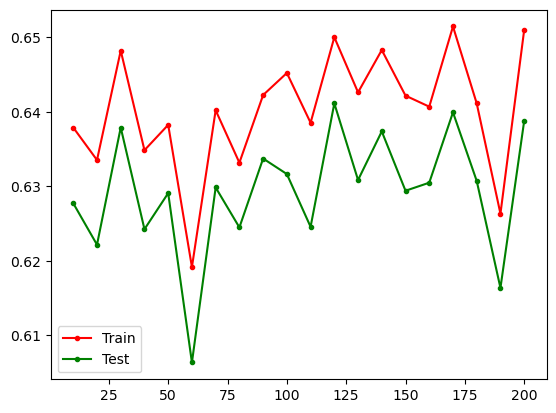

In [20]:
# Testing different hidden layer sizes
layer_sizes = [np.array([value]) for value in np.arange(10, 201, 10)] # Note: 100 dimensional vector_size
layers = [val for val in np.arange(10, 201, 10)]
tester('hidden_layer_sizes', layer_sizes, train_size, layers)

Building model activation: identity
Building model activation: logistic
Building model activation: tanh
Building model activation: relu


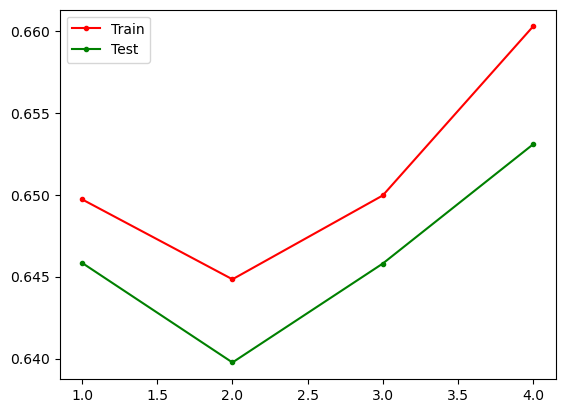

In [48]:
default['hidden_layer_sizes'] = np.array([180])
# Test different activations
activations = ['identity', 'logistic', 'tanh', 'relu']
activation_errors = [1, 2, 3, 4] # Just so it is graphable
tester('activation', activations, train_size, activation_errors)

Building model solver: lbfgs
Building model solver: sgd
Building model solver: adam


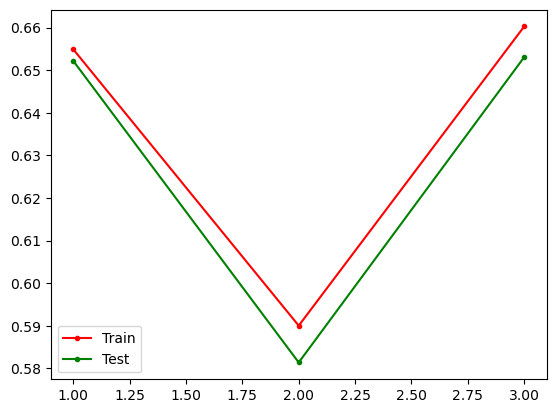

In [49]:
# Test different solvers
solvers = ['lbfgs', 'sgd', 'adam']
solver_errors = [1, 2, 3] # Just so it is graphable
tester('solver', solvers, train_size, solver_errors)

Building model alpha: 0.0001
Building model alpha: 0.0006000000000000001
Building model alpha: 0.0011
Building model alpha: 0.0016
Building model alpha: 0.0021
Building model alpha: 0.0026
Building model alpha: 0.0031
Building model alpha: 0.0036
Building model alpha: 0.0041
Building model alpha: 0.004600000000000001
Building model alpha: 0.0051
Building model alpha: 0.0056
Building model alpha: 0.0061
Building model alpha: 0.006600000000000001
Building model alpha: 0.0071
Building model alpha: 0.0076
Building model alpha: 0.0081
Building model alpha: 0.0086
Building model alpha: 0.0091
Building model alpha: 0.0096


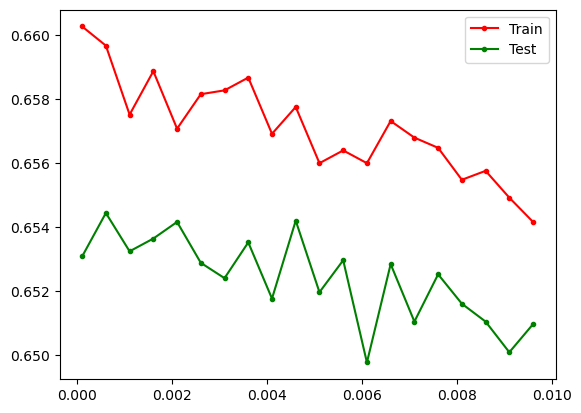

In [50]:
# Test different alpha levels
alphas = np.arange(0.0001, 0.01, 0.0005)
tester('alpha', alphas, train_size, alphas)

Building model batch_size: 100
Building model batch_size: 150
Building model batch_size: 200
Building model batch_size: 250
Building model batch_size: 300
Building model batch_size: 350
Building model batch_size: 400
Building model batch_size: 450
Building model batch_size: 500
Building model batch_size: 550
Building model batch_size: 600
Building model batch_size: 650
Building model batch_size: 700
Building model batch_size: 750
Building model batch_size: 800
Building model batch_size: 850
Building model batch_size: 900
Building model batch_size: 950


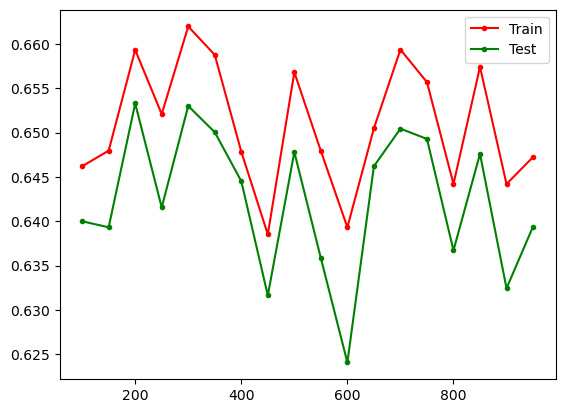

In [52]:
default['alpha'] = 0.0005
# Test different batch sizes
batch_sizes = np.arange(100, 1000, 50)
tester('batch_size', batch_sizes, train_size, batch_sizes)

Building model learning_rate: constant
Building model learning_rate: invscaling
Building model learning_rate: adaptive


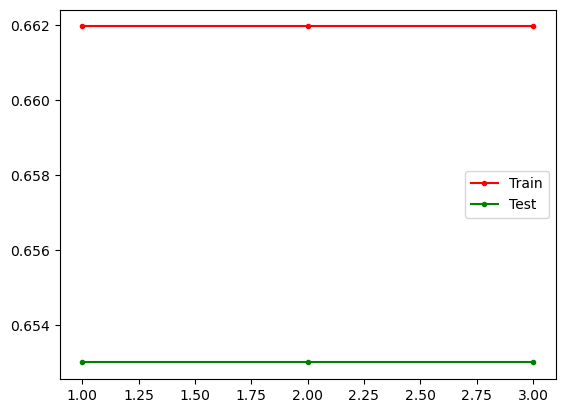

In [53]:
default['batch_size'] = 300
# Test different learning rates
learning_rates = ['constant', 'invscaling', 'adaptive']
rate_count = [1, 2, 3]
tester('learning_rate', learning_rates, train_size, rate_count)

Building model learning_rate_init: 0.001
Building model learning_rate_init: 0.006
Building model learning_rate_init: 0.011
Building model learning_rate_init: 0.016
Building model learning_rate_init: 0.021
Building model learning_rate_init: 0.026000000000000002
Building model learning_rate_init: 0.031
Building model learning_rate_init: 0.036000000000000004
Building model learning_rate_init: 0.041
Building model learning_rate_init: 0.046
Building model learning_rate_init: 0.051000000000000004
Building model learning_rate_init: 0.056
Building model learning_rate_init: 0.061
Building model learning_rate_init: 0.066
Building model learning_rate_init: 0.07100000000000001
Building model learning_rate_init: 0.076
Building model learning_rate_init: 0.081
Building model learning_rate_init: 0.08600000000000001
Building model learning_rate_init: 0.091
Building model learning_rate_init: 0.096


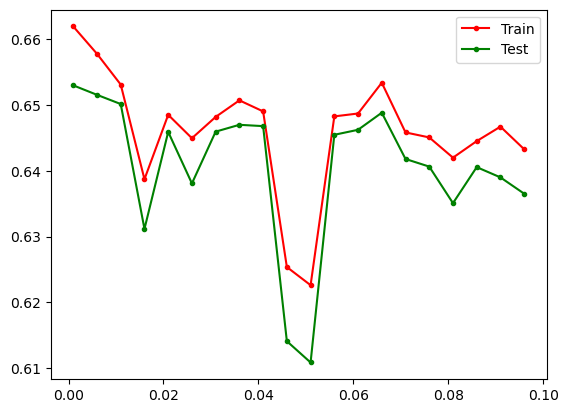

In [56]:
# Test learning rate init size
learning_rate_inits = np.arange(0.001, 0.1, 0.005)
tester('learning_rate_init', learning_rate_inits, train_size, learning_rate_inits)

Building model max_iter: 10
Building model max_iter: 20
Building model max_iter: 30
Building model max_iter: 40
Building model max_iter: 50
Building model max_iter: 60
Building model max_iter: 70
Building model max_iter: 80
Building model max_iter: 90
Building model max_iter: 100
Building model max_iter: 110
Building model max_iter: 120
Building model max_iter: 130
Building model max_iter: 140
Building model max_iter: 150
Building model max_iter: 160
Building model max_iter: 170
Building model max_iter: 180
Building model max_iter: 190
Building model max_iter: 200
Building model max_iter: 210
Building model max_iter: 220
Building model max_iter: 230
Building model max_iter: 240
Building model max_iter: 250
Building model max_iter: 260
Building model max_iter: 270
Building model max_iter: 280
Building model max_iter: 290
Building model max_iter: 300
Building model max_iter: 310
Building model max_iter: 320
Building model max_iter: 330
Building model max_iter: 340
Building model max_iter

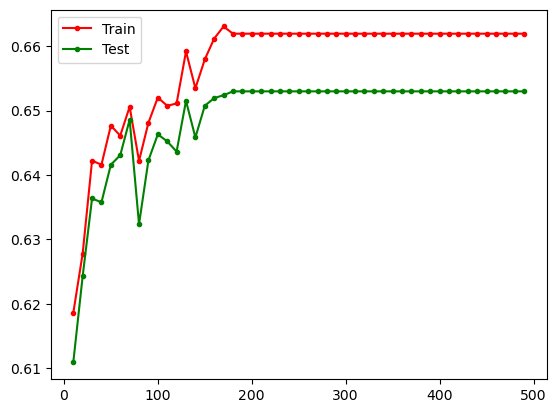

In [57]:
# Test max iter
max_iters = np.arange(10, 500, 10)
tester('max_iter', max_iters, train_size, max_iters)

Models did not show better results when increasing/decreasing parameter values. As such, a grid
search is performed to see if the current model's accuracy of 0.65 is possible.

In [8]:
# Grid search
from sklearn.model_selection import GridSearchCV

mlp = MLPClassifier()
params = {
    "hidden_layer_sizes": [np.array([size]) for size in np.arange(50, 201, 50)],
    "activation": ['logistic', 'tanh', 'relu'],
    "solver": ['sgd'],
    "alpha": np.arange(0.0001, 0.003, 0.001),
    "batch_size": np.arange(200, 301, 50),
    "learning_rate": ['constant', 'invscaling', 'adaptive'],
    "learning_rate_init": np.arange(0.001, 0.03, 0.01),
    # "max_iter": max_iters # did not improve
}
print("Running Grid Search...")
clf = GridSearchCV(mlp, params)
clf.fit(X_train, Y_train)
print("Finished Grid Search.")

Running Grid Search...
Finished Grid Search.


In [9]:
clf.best_params_

{'activation': 'relu',
 'alpha': 0.0011,
 'batch_size': 200,
 'hidden_layer_sizes': array([150]),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.020999999999999998,
 'solver': 'sgd'}

In [11]:
best_params_one_layer = {
    'activation': 'relu',
    'alpha': 0.001,
    'batch_size': 200,
    'hidden_layer_sizes': np.array([150]),
    'learning_rate': 'adaptive',
    'learning_rate_init': 0.02,
    'solver': 'sgd',
    'random_state': seed
}

In [15]:
df_results = pd.DataFrame(clf.cv_results_)
df_results.to_csv('./data/feedforwardNN-1_layer.csv', index=False)
df_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_learning_rate_init,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.529892,0.022298,0.003125,0.006251,logistic,0.0001,200,[50],constant,0.001,sgd,"{'activation': 'logistic', 'alpha': 0.0001, 'b...",0.5060,0.5000,0.5382,0.5062,0.4758,0.50524,0.019910,834
1,8.346323,0.091670,0.003126,0.006252,logistic,0.0001,200,[50],constant,0.011,sgd,"{'activation': 'logistic', 'alpha': 0.0001, 'b...",0.6108,0.6098,0.5968,0.5912,0.5920,0.60012,0.008536,370
2,8.336259,0.046370,0.003122,0.006245,logistic,0.0001,200,[50],constant,0.021,sgd,"{'activation': 'logistic', 'alpha': 0.0001, 'b...",0.6508,0.6478,0.6216,0.6278,0.6358,0.63676,0.011225,267
3,0.547828,0.009392,0.006832,0.006212,logistic,0.0001,200,[50],invscaling,0.001,sgd,"{'activation': 'logistic', 'alpha': 0.0001, 'b...",0.4966,0.5020,0.4770,0.5000,0.5048,0.49608,0.009907,947
4,0.538172,0.044691,0.001304,0.001604,logistic,0.0001,200,[50],invscaling,0.011,sgd,"{'activation': 'logistic', 'alpha': 0.0001, 'b...",0.5000,0.4928,0.5000,0.5000,0.5002,0.49860,0.002901,929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,0.849617,0.063531,0.006251,0.007655,relu,0.0021,300,[200],invscaling,0.011,sgd,"{'activation': 'relu', 'alpha': 0.0021, 'batch...",0.5070,0.5082,0.5184,0.5010,0.5072,0.50836,0.005625,805
968,0.896553,0.051562,0.012506,0.006253,relu,0.0021,300,[200],invscaling,0.021,sgd,"{'activation': 'relu', 'alpha': 0.0021, 'batch...",0.5678,0.5306,0.5372,0.5184,0.5444,0.53968,0.016459,611
969,5.312066,0.399566,0.005626,0.006961,relu,0.0021,300,[200],adaptive,0.001,sgd,"{'activation': 'relu', 'alpha': 0.0021, 'batch...",0.5520,0.5582,0.5610,0.5532,0.5406,0.55300,0.007012,523
970,12.769010,0.202995,0.006260,0.007667,relu,0.0021,300,[200],adaptive,0.011,sgd,"{'activation': 'relu', 'alpha': 0.0021, 'batch...",0.6494,0.6512,0.6298,0.6314,0.6440,0.64116,0.008956,189


In [16]:
sorted(df_results, key=df_results["rank_test_score"])

TypeError: 'Series' object is not callable

In [17]:
sorted_df_results = df_results.sort_values(by=["rank_test_score"])
sorted_df_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_learning_rate_init,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
782,12.120278,0.543126,0.000000,0.000000,relu,0.0011,200,[150],adaptive,0.021,sgd,"{'activation': 'relu', 'alpha': 0.0011, 'batch...",0.6612,0.6684,0.6302,0.6348,0.6492,0.64876,0.014697,1
917,9.422231,0.086089,0.003127,0.006253,relu,0.0021,250,[100],adaptive,0.021,sgd,"{'activation': 'relu', 'alpha': 0.0021, 'batch...",0.6632,0.6644,0.6344,0.6336,0.6458,0.64828,0.013392,2
890,12.013326,0.814361,0.003229,0.006457,relu,0.0021,200,[150],adaptive,0.021,sgd,"{'activation': 'relu', 'alpha': 0.0021, 'batch...",0.6628,0.6658,0.6310,0.6348,0.6470,0.64828,0.014140,2
773,10.469062,0.152338,0.003533,0.006097,relu,0.0011,200,[100],adaptive,0.021,sgd,"{'activation': 'relu', 'alpha': 0.0011, 'batch...",0.6616,0.6622,0.6344,0.6346,0.6468,0.64792,0.012268,4
764,7.709845,0.045550,0.003125,0.006249,relu,0.0011,200,[50],adaptive,0.021,sgd,"{'activation': 'relu', 'alpha': 0.0011, 'batch...",0.6602,0.6654,0.6372,0.6338,0.6428,0.64788,0.012624,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,0.928488,0.031909,0.012507,0.006253,logistic,0.0011,200,[150],invscaling,0.001,sgd,"{'activation': 'logistic', 'alpha': 0.0011, 'b...",0.4862,0.5002,0.4726,0.5000,0.5000,0.49180,0.011000,968
957,0.715260,0.028778,0.003125,0.006250,relu,0.0021,300,[150],invscaling,0.001,sgd,"{'activation': 'relu', 'alpha': 0.0021, 'batch...",0.5068,0.5004,0.4838,0.5012,0.4644,0.49132,0.015498,969
30,1.113188,0.056435,0.015640,0.000023,logistic,0.0001,200,[200],invscaling,0.001,sgd,"{'activation': 'logistic', 'alpha': 0.0001, 'b...",0.4382,0.5000,0.4998,0.4988,0.5046,0.48828,0.025120,970
741,0.715208,0.037706,0.009377,0.007656,relu,0.0001,300,[150],invscaling,0.001,sgd,"{'activation': 'relu', 'alpha': 0.0001, 'batch...",0.4632,0.4870,0.4998,0.4982,0.4926,0.48816,0.013269,971


In [12]:
# Test best params vs best found manually
manualClf = MLPClassifier(**default)
manualClf.fit(X_train, Y_train)
yPredManual = manualClf.predict(X_train)
yPredManualTest = manualClf.predict(X_test)
gridClf = MLPClassifier(**best_params_one_layer)
gridClf.fit(X_train, Y_train)
yPredGrid = gridClf.predict(X_train)
yPredGridTest = gridClf.predict(X_test)
print(f"Manual\tTrain:{accuracy_score(Y_train, yPredManual)} Test:{accuracy_score(Y_test, yPredManualTest)}")
print(f"Grid\tTrain:{accuracy_score(Y_train, yPredGrid)} Test: {accuracy_score(Y_test, yPredGridTest)}")

Manual	Train:0.66216 Test:0.6544
Grid	Train:0.65328 Test: 0.64872


In [ ]:
# Manual performed better than grid search.
best_params_one_layer = default

Building model hidden_layer_sizes: [180  10]
Building model hidden_layer_sizes: [180  20]
Building model hidden_layer_sizes: [180  30]
Building model hidden_layer_sizes: [180  40]
Building model hidden_layer_sizes: [180  50]
Building model hidden_layer_sizes: [180  60]
Building model hidden_layer_sizes: [180  70]
Building model hidden_layer_sizes: [180  80]
Building model hidden_layer_sizes: [180  90]
Building model hidden_layer_sizes: [180 100]
Building model hidden_layer_sizes: [180 110]
Building model hidden_layer_sizes: [180 120]
Building model hidden_layer_sizes: [180 130]
Building model hidden_layer_sizes: [180 140]
Building model hidden_layer_sizes: [180 150]
Building model hidden_layer_sizes: [180 160]
Building model hidden_layer_sizes: [180 170]
Building model hidden_layer_sizes: [180 180]
Building model hidden_layer_sizes: [180 190]
Building model hidden_layer_sizes: [180 200]
Building model hidden_layer_sizes: [180 210]
Building model hidden_layer_sizes: [180 220]
Building m

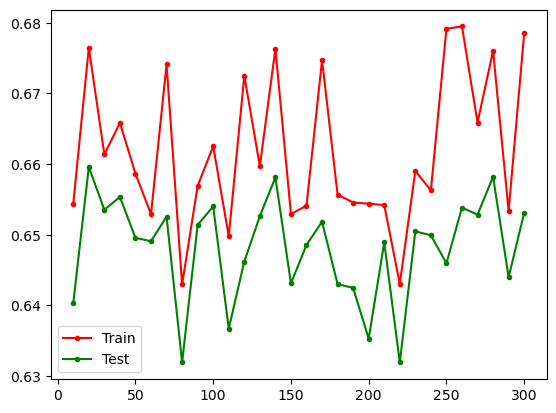

In [14]:
# Try adding a second layer?
second_layer_sizes = [np.array([180, layer_size]) for layer_size in np.arange(10, 301, 10)]
sizes = [i for i in np.arange(10, 301, 10)]
tester('hidden_layer_sizes', second_layer_sizes, train_size, sizes)

In [15]:
# Multi-layer NN performed better
default['hidden_layer_sizes'] = np.array([180, 140])

In [12]:
# Try larger word embeddings?
# Try tokenizing sentences?
from nltk.tokenize import word_tokenize
vector_size = 300
print("Building model...")
w2v_model = Word2Vec(sentences=[word_tokenize(line) for line in df_train["text"]], vector_size = vector_size, window=5, min_count=1)

def vectorize_sentences(sentences, model, vector_size):
    vectors = []
    for sentence in sentences:
        sentence_vec = np.zeros(vector_size)
        for word in sentence:
            if word in model.wv:
                sentence_vec += model.wv[word]
        vectors.append(sentence_vec / len(sentence))
    return np.array(vectors)

print("Vectorizing training...")
X_train = vectorize_sentences(df_train["text"], w2v_model, vector_size = vector_size)
Y_train = df_train["label"]
print("Vectorizing testing...")
X_test = vectorize_sentences(df_test["text"], w2v_model, vector_size = vector_size)
Y_test = df_test["label"]

Building model...
Vectorizing training...
Vectorizing testing...


In [ ]:
layer_sizes = [np.array([size]) for size in np.arange(50, 1000, 50)]
layer_xs = [size for size in np.arange(50, 1000, 50)]
tester('hidden_layer_sizes', layer_sizes, train_size=train_size, x_values = layer_xs)

Building model hidden_layer_sizes: [50]
Building model hidden_layer_sizes: [100]
Building model hidden_layer_sizes: [150]
Building model hidden_layer_sizes: [200]
Building model hidden_layer_sizes: [250]
Building model hidden_layer_sizes: [300]
Building model hidden_layer_sizes: [350]
Building model hidden_layer_sizes: [400]
Building model hidden_layer_sizes: [450]
Building model hidden_layer_sizes: [500]
Building model hidden_layer_sizes: [550]
Building model hidden_layer_sizes: [600]
Building model hidden_layer_sizes: [650]
Building model hidden_layer_sizes: [700]
Building model hidden_layer_sizes: [750]
Building model hidden_layer_sizes: [800]
Building model hidden_layer_sizes: [850]
